# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Gather Data

### In this chapter the required data is gathered and briefly analyzed.

In [2]:
portfolio.head(3)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


In [3]:
profile.head(3)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN


In [4]:
transcript.head(3)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}


In [5]:
# 2,175 NULL values present in columns 'gender' and 'income'
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [6]:
# max age of 118 years might be an outlier
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


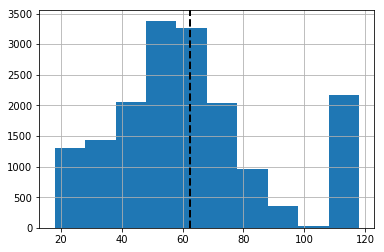

In [7]:
# distribution of the 'age' column including the mean of 'age'
profile['age'].hist()
plt.axvline(profile['age'].mean(), color='k', linestyle='dashed', linewidth=2);

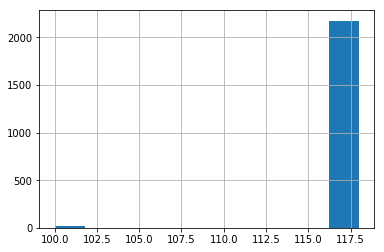

In [8]:
# distribution of 'age' greater than or equal to 100
profile[profile['age'] >= 100]['age'].hist();

In [9]:
# count of 'user_ids' where 'age' is greate than or equal to 110.
# 2,175 users have an age of equal or mare than 110 which doesn't see valid 
profile[profile['age'] >= 110]['age'].count()

2175

In [10]:
# the first sign up was on July 29th 2013 and the most recent sign up was on July 26th 2018
print(profile['became_member_on'].min()), print(profile['became_member_on'].max())

20130729
20180726


(None, None)

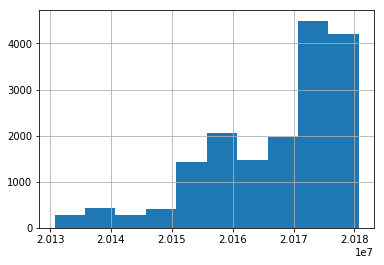

In [11]:
# distribution of the 'became_member_on' column
profile['became_member_on'].hist();

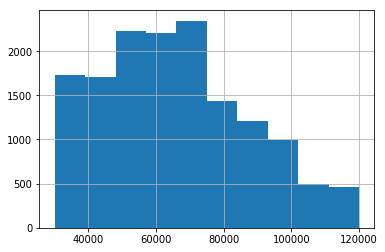

In [12]:
# distribution of the 'income' column
profile['income'].hist();

In [13]:
# count by 'gender'
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [14]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
# counts by 'event'
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

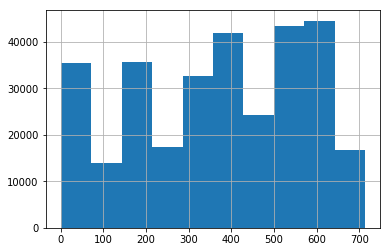

In [16]:
transcript['time'].hist();

# 2. Clean Data
### In this chapter the required data is cleaned to provide meaningful insights in the Exploratory Analysis later.

### 2.1 Clean 'portfolio' DataFrame

In [17]:
# create a copy of the original DataFrame
portfolio_clean = portfolio.copy()

In [18]:
# create dummy variables for 'offer_type'
offer_type_dummy = pd.get_dummies(portfolio_clean['offer_type'])
# concatenate DataFrame 'portfolio' and offer_type_dummy
portfolio_clean = pd.concat([portfolio_clean, offer_type_dummy], axis = 1)

In [19]:
# create dummy variables for 'channels'
channel_dummy = portfolio_clean['channels'].map(lambda x: ','.join(map(str, x))).str.get_dummies(sep=',')
# concatenate DataFrame 'portfolio' and channel_dummy
portfolio_clean = pd.concat([portfolio_clean, channel_dummy], axis = 1)

In [20]:
# convert column 'duration' from days to hours to match with 'transcript' DataFrame
portfolio_clean['duration'] = portfolio_clean['duration'] * 24

In [21]:
# rename column 'id' to 'offer_id'
portfolio_clean.rename(columns = {'id':'offer_id'}, inplace = True)

In [22]:
# create offer_name based on offer_type, 'difficulty', and 'duration'
portfolio_clean['offer_name'] = portfolio_clean['offer_type'].astype(str) + '_' + portfolio_clean['difficulty'].astype(str) + '_' + portfolio_clean['duration'].astype(str)

### 2.2 Clean 'profile' DataFrame

In [23]:
# create a copy of the original DataFrame
profile_clean = profile.copy()

In [24]:
# store ids of user with an age of 110 and higher in variable age_110 to be able to delete these rows from other DataFrames later
age_110 = profile_clean[profile_clean['age'] >= 110]['id']

In [25]:
# drop rows where age is higher than 110 years
profile_clean.drop(profile_clean[profile_clean['age'] >= 110].index, inplace = True) 

In [26]:
# convert from integer to datetime64
profile_clean['became_member_on'] = profile_clean['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [27]:
# year of 'became_member_on' date
profile_clean['became_member_year'] = profile_clean['became_member_on'].dt.year

In [28]:
# days between today and 'became_member_on' date
profile_clean['member_days'] = datetime.datetime.now() - profile_clean['became_member_on']
profile_clean['member_days'] = profile_clean['member_days'].dt.days

In [29]:
# create variables for 'gender'
gender_dummy = pd.get_dummies(profile_clean['gender'])
# concatenate DataFrame 'profile' and gender_dummy
profile_clean = pd.concat([profile_clean, gender_dummy], axis = 1)

In [30]:
# create dummy variables that represent the century of the customer's age
def add_year_decade(val):
    val = str(val)
    if val[0] == yr:
        return 1
    else:
        return 0
    
for yr in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']:
    profile_clean[str(yr) + "0s"] = profile_clean['age'].apply(add_year_decade)

In [31]:
# rename 'id' to 'user_id'
profile_clean.rename(columns = {'id':'user_id'}, inplace = True)

In [32]:
# create income groups
profile_clean.loc[profile_clean['income'] < 40000, 'income_group'] = 'low'
profile_clean.loc[(profile_clean['income'] >= 40000) & (profile_clean['income'] <= 90000), ['income_group']] = 'medium' 
profile_clean.loc[profile_clean['income'] > 90000, 'income_group'] = 'high'

In [33]:
# create variables for 'income_group_dummy'
income_group_dummy = pd.get_dummies(profile_clean['income_group'])
# concatenate DataFrame 'profile' and income_group_dummy
profile_clean = pd.concat([profile_clean, income_group_dummy], axis = 1)

In [34]:
profile_clean.head()

,age,became_member_on,gender,user_id,income,became_member_year,member_days,F,M,O,...,50s,60s,70s,80s,90s,100s,income_group,high,low,medium
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1332,1,0,0,...,1,0,0,0,0,0,high,1,0,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1399,1,0,0,...,0,0,1,0,0,0,high,1,0,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,1047,0,1,0,...,0,1,0,0,0,0,medium,0,0,1
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,1123,0,1,0,...,0,1,0,0,0,0,medium,0,0,1
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1213,0,1,0,...,1,0,0,0,0,0,medium,0,0,1


### 2.3 Clean 'transcript' DataFrame and create 'transactions' DataFrame

In [35]:
# create a copy of the original DataFrame
transcript_clean = transcript.copy()

In [36]:
# create Pandas Series 'offer_id' based on Pandas Series 'value'
transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x['offer id'] if 'offer id' in x else (x['offer_id'] if 'offer_id' in x else np.nan))
# create Pandas Series 'offer_id' based on Pandas Series 'value'
transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: x['amount'] if ('amount' in x) else np.nan)

In [37]:
# rename 'person' to 'user_id'
transcript_clean.rename(columns = {'person':'user_id'}, inplace = True)

In [38]:
# create DataFrame 'transactions' from 'transcript' DataFrame by using the 'user_id' and 'amount'
transactions = transcript_clean.loc[transcript_clean['event'] == 'transaction', ['user_id', 'time' ,'amount']]
transactions.reset_index(drop = True, inplace = True)

In [39]:
# drop rows where 'event' equals 'transcation'
transcript_clean.drop(transcript_clean[transcript_clean['event'] == 'transaction'].index, inplace = True) 

In [40]:
# drop column 'value'
transcript_clean.drop(columns = ['value', 'amount'], axis = 1, inplace = True)

In [41]:
# create dummy variables for 'event'
event_dummy = pd.get_dummies(transcript_clean['event'])
# concatenate DataFrame 'transcript' and event_dummy
transcript_clean = pd.concat([transcript_clean, event_dummy], axis = 1)

In [42]:
# rename multiple columns in the transcript DataFrame
transcript_clean.rename(columns = {'offer completed':'offer_completed', 'offer received':'offer_received', 'offer viewed':'offer_viewed'}, inplace = True)

In [43]:
# drop column 'event'
transcript_clean.drop('event', axis = 1, inplace = True)

In [44]:
# remove rows where user_id matches user_id in age_110 list
transcript_clean = transcript_clean[~transcript_clean['user_id'].isin(age_110)] 

In [45]:
# remove rows where user_id matches user_id in age_110 list
transcript_clean = transcript_clean[~transcript_clean['user_id'].isin(age_110)] 

In [46]:
# inner join between 'profile_clean' and 'transcript_clean' on 'user_id'
master_df = profile_clean.merge(transcript_clean, how = 'inner', on = 'user_id')

In [47]:
# inner join between 'master_df' and 'portfolio_clean' on 'offer_id'
master_df = master_df.merge(portfolio_clean, how = 'inner', on = 'offer_id')

In [48]:
master_df.head()

,age,became_member_on,gender,user_id,income,became_member_year,member_days,F,M,O,...,offer_type,reward,bogo,discount,informational,email,mobile,social,web,offer_name
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1332,1,0,0,...,bogo,5,1,0,0,1,1,0,1,bogo_5_168
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,1332,1,0,0,...,bogo,5,1,0,0,1,1,0,1,bogo_5_168
2,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1399,1,0,0,...,bogo,5,1,0,0,1,1,0,1,bogo_5_168
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1399,1,0,0,...,bogo,5,1,0,0,1,1,0,1,bogo_5_168
4,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,1399,1,0,0,...,bogo,5,1,0,0,1,1,0,1,bogo_5_168


In [49]:
# no NULL values
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 42 columns):
age                   148805 non-null int64
became_member_on      148805 non-null datetime64[ns]
gender                148805 non-null object
user_id               148805 non-null object
income                148805 non-null float64
became_member_year    148805 non-null int64
member_days           148805 non-null int64
F                     148805 non-null uint8
M                     148805 non-null uint8
O                     148805 non-null uint8
10s                   148805 non-null int64
20s                   148805 non-null int64
30s                   148805 non-null int64
40s                   148805 non-null int64
50s                   148805 non-null int64
60s                   148805 non-null int64
70s                   148805 non-null int64
80s                   148805 non-null int64
90s                   148805 non-null int64
100s                  148805 non-null in

# 3. Exploratory Data Analysis

### Questions:

- How many new members does Starbucks get each year and what's the projection for 2018?
- What's the age distribution?
- How is the is the income distributed across genders?
- What's the viewing rate of each offer by gender?
- What's the viewing rate of each offer and income group?
- What's the completion rate of each offer?
- What's the completion rate of each offer by gender?
- How long does it take in average to complete an offer?
- How long dies it take in average to complete an offer based on the maximum duration?
- How much money that was spent is associated with a completed offer?

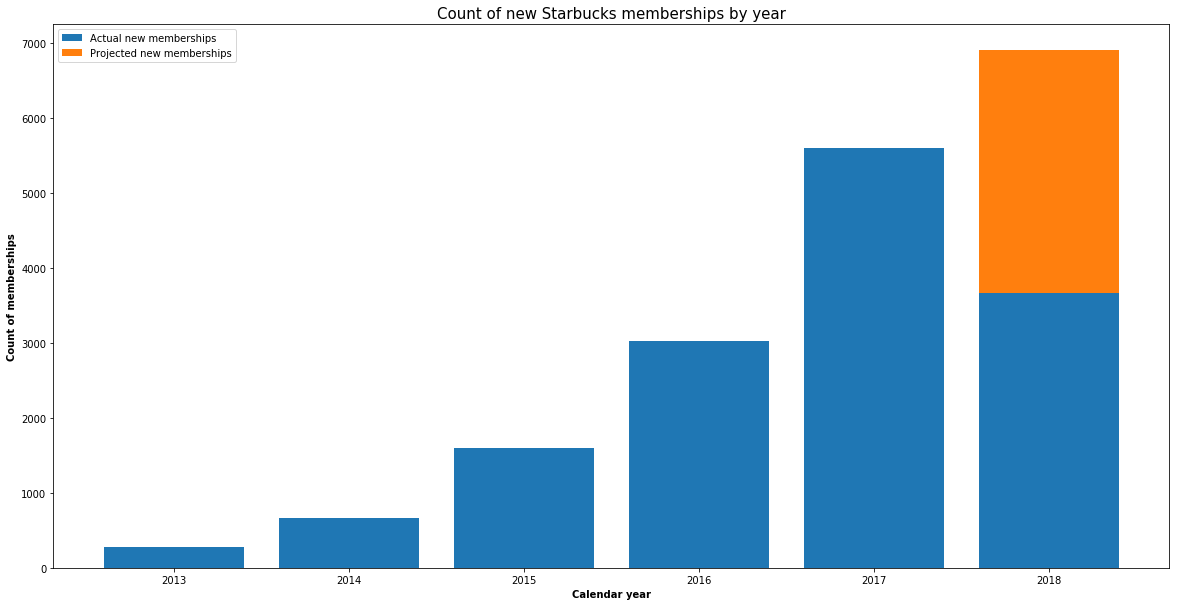

In [80]:
# group by count of new memberships by month to depict seasonal trend
avg_new_memb_month = profile_clean['became_member_on'].groupby([profile_clean.became_member_on.dt.month]).count()/profile_clean['became_member_on'].count()
# the last 6 month account for roughly 53.35% of new memberships in 2018
perc_last6month = avg_new_memb_month.iloc[6:].sum()
# projected count of new memberships in 2018
proj_new_memb_2018 = profile_clean[(profile_clean.became_member_on.dt.month <= 6) & (profile_clean.became_member_on.dt.year == 2018)]['became_member_year'].count()/(1 -  perc_last6month)
# projected count of memberships for 2018 - actual count of membership up to June 30th 2018
proj_2018 = proj_new_memb_2018 - profile_clean.groupby('became_member_year')['became_member_year'].count().values[-1]

N = len(profile_clean.groupby('became_member_year')['became_member_year'].count().index.values)
ind = np.arange(N)

# set bar width
barWidth = 0.35

# set figure size
plt.figure(figsize=(20,10))
 
# set height of bar
bars1 = profile_clean.groupby('became_member_year')['became_member_year'].count().values
bars2 = np.array([0, 0, 0, 0, 0, proj_2018])
 
# Add xticks on the middle of the group bars
plt.title('Count of new Starbucks memberships by year', fontsize = 15)
plt.ylabel('Count of memberships', fontweight ="bold")
plt.xlabel('Calendar year', fontweight ="bold")
plt.bar(profile_clean.groupby('became_member_year')['became_member_year'].count().index.values, bars1, label = 'Actual new memberships')
plt.bar(profile_clean.groupby('became_member_year')['became_member_year'].count().index.values, bars2, bottom = bars1, label = 'Projected new memberships')
plt.legend()
# Create legend & Show graphic
plt.show()

There is an constant increase of new memberships each year since 2013. Since there's only membership data included up to July 26th 2018, the count of new memberships in 2018 is misleading, as it takes in account the first 206 days or 56,5% of the year. Based on the calculation above there will be roughly 6,900 new members in 2018, which is an increase of 23,24% compared to 5,599 new memberships in 2017.

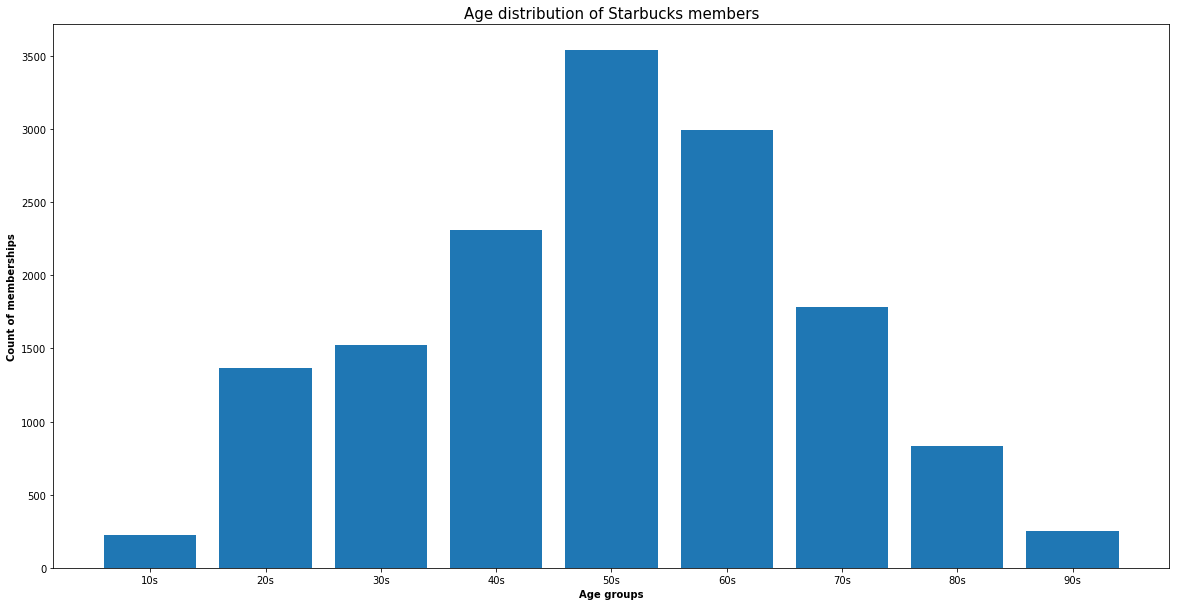

In [51]:
column_name = []
column_val = []
for age_column in profile_clean[["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"]]:
    column_name.append(profile_clean[age_column].name)
    column_val.append(profile_clean[age_column].sum())
    
plt.figure(figsize=(20,10))
plt.bar(column_name, column_val)
plt.title('Age distribution of Starbucks members', fontsize = 15)
plt.xlabel('Age groups', fontweight ="bold")
plt.ylabel('Count of memberships', fontweight ="bold")
plt.show();

The age of Starbucks members looks normally distributed which is in contrast to the age distribution of the US population: https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf. Most of the Starbucks members are in their 50's and 60's

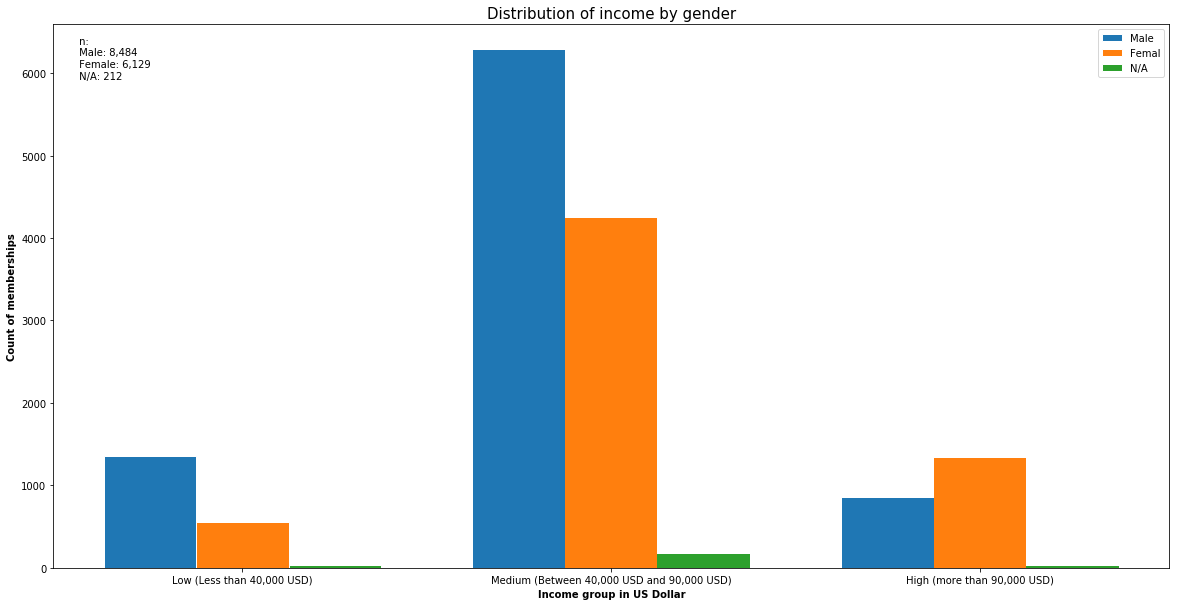

In [52]:
n_men = profile_clean[profile_clean['gender']== 'M']['gender'].count()
n_women = profile_clean[profile_clean['gender']== 'F']['gender'].count()
n_na = profile_clean[profile_clean['gender']== 'O']['gender'].count()
string = " n: \n Male: {:,}  \n Female: {:,}  \n N/A: {:,}".format(n_men, n_women, n_na)

# convert 'income_group' to a categorical 
level_order = ['low', 'medium', 'high']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = level_order)
profile_clean['income_group']= profile_clean['income_group'].astype(ordered_cat)

# set bar width
barWidth = 0.25

# set figure size
plt.figure(figsize=(20,10))

r1 = np.arange(len(profile_clean.groupby('income_group')['income_group'].count().index.values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# set height of bar
plt.bar(r1, profile_clean[profile_clean['gender']== 'M'].groupby('income_group')['gender'].count().values, width=barWidth, edgecolor='white', label='Male')
plt.bar(r2, profile_clean[profile_clean['gender']== 'F'].groupby('income_group')['gender'].count().values, width=barWidth, edgecolor='white', label='Femal')
plt.bar(r3, profile_clean[profile_clean['gender']== 'O'].groupby('income_group')['gender'].count().values, width=barWidth, edgecolor='white', label='N/A')
 
# Add xticks on the middle of the group bars
plt.title('Distribution of income by gender', fontsize = 15)
plt.ylabel('Count of memberships', fontweight ="bold")
plt.xlabel('Income group in US Dollar', fontweight ="bold")
plt.xticks([r + barWidth for r in range(len(profile_clean.groupby('income_group')['income_group'].count().index.values))], ['Low (Less than 40,000 USD)', 'Medium (Between 40,000 USD and 90,000 USD)', 'High (more than 90,000 USD)'])
plt.annotate(string, xy=(0.02, 0.90), xycoords='axes fraction')
plt.legend()
# Create legend & Show graphic
plt.show()

There are roughly 38% more male than female members. There are more female members in the high income groupe despite the total amount of females is lower. 

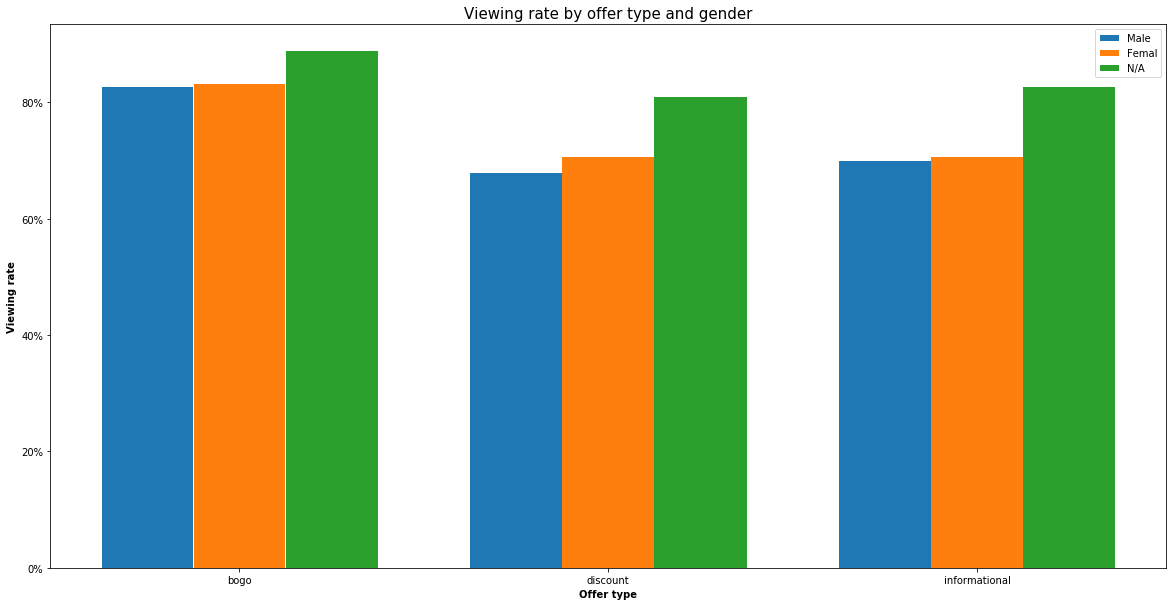

In [53]:
m_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['gender'] == 'M')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['gender'] == 'M')].groupby('offer_type')['offer_type'].count().values)
f_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['gender'] == 'F')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['gender'] == 'F')].groupby('offer_type')['offer_type'].count().values)
o_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['gender'] == 'O')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['gender'] == 'O')].groupby('offer_type')['offer_type'].count().values)
# set bar width
barWidth = 0.25

# set figure size
plt.figure(figsize=(20,10))

r1 = np.arange(len(master_df.groupby('offer_type')['offer_type'].count().index.values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# set height of bar
plt.bar(r1, m_viewed_received, width=barWidth, edgecolor='white', label='Male')
plt.bar(r2, f_viewed_received, width=barWidth, edgecolor='white', label='Femal')
plt.bar(r3, o_viewed_received, width=barWidth, edgecolor='white', label='N/A')
 
# Add xticks on the middle of the group bars
plt.title('Viewing rate by offer type and gender', fontsize = 15)
plt.ylabel('Viewing rate', fontweight ="bold")
plt.xlabel('Offer type', fontweight ="bold")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.xticks([r + barWidth for r in range(len(master_df.groupby('offer_type')['offer_type'].count().index.values))], master_df[master_df['offer_received'] == 1].groupby('offer_type')['user_id'].count().index)
plt.legend()
# Create legend & Show graphic
plt.show()

The Buy one get one (BOGO) offer type has the highest viewing rate out of the three offer types. Not available genders have the highest viewing rate although the sample size of this subset is significantly compared to the male and femal subset. Female members have a slightly higher viewing rate than male members.  

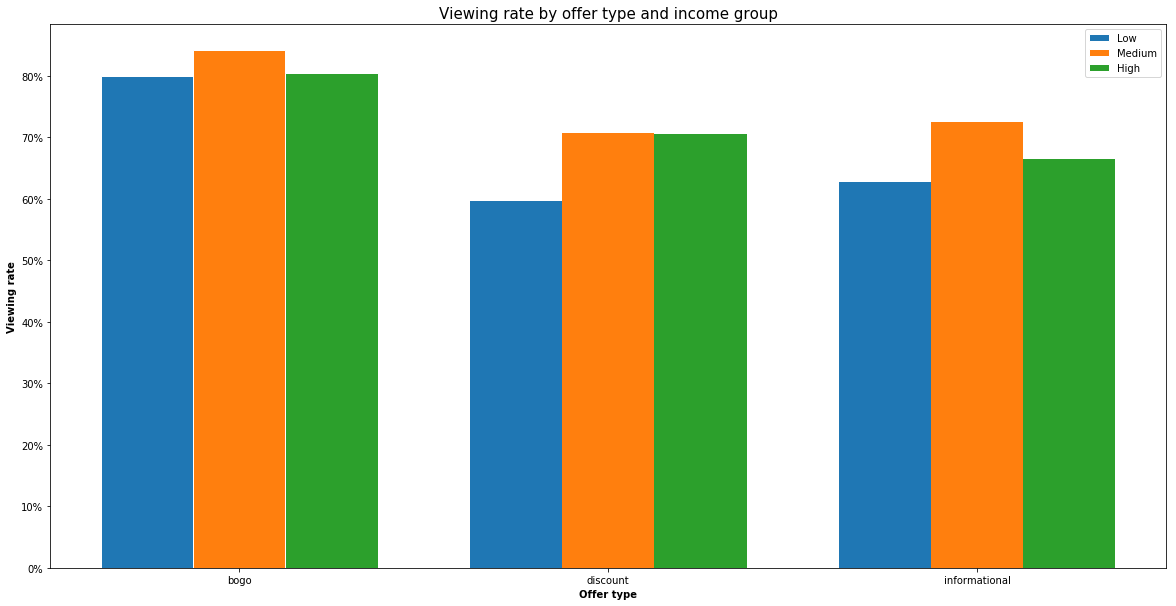

In [54]:
l_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['income_group'] == 'low')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['income_group'] == 'low')].groupby('offer_type')['offer_type'].count().values)
m_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['income_group'] == 'medium')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['income_group'] == 'medium')].groupby('offer_type')['offer_type'].count().values)
h_viewed_received = (master_df[(master_df['offer_viewed'] == 1) & (master_df['income_group'] == 'high')].groupby('offer_type')['offer_type'].count().values)/(master_df[(master_df['offer_received'] == 1) & (master_df['income_group'] == 'high')].groupby('offer_type')['offer_type'].count().values)
# set bar width
barWidth = 0.25

# set figure size
plt.figure(figsize=(20,10))

r1 = np.arange(len(master_df.groupby('offer_type')['offer_type'].count().index.values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# set height of bar
plt.bar(r1, l_viewed_received, width=barWidth, edgecolor='white', label='Low')
plt.bar(r2, m_viewed_received, width=barWidth, edgecolor='white', label='Medium')
plt.bar(r3, h_viewed_received, width=barWidth, edgecolor='white', label='High')
 
# Add xticks on the middle of the group bars
plt.title('Viewing rate by offer type and income group', fontsize = 15)
plt.ylabel('Viewing rate', fontweight ="bold")
plt.xlabel('Offer type', fontweight ="bold")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.xticks([r + barWidth for r in range(len(master_df.groupby('offer_type')['offer_type'].count().index.values))], master_df[master_df['offer_received'] == 1].groupby('offer_type')['user_id'].count().index)
plt.legend()
# Create legend & Show graphic
plt.show()

Bogo offers have to highest viewing rate across all income groups. Discout and informational offers have a pretty similar viewing rate. Nembers in the low income group have the lowest viewing rate. 

In [55]:
# create DataFrame where offer_completed is true and sort by time ascending
df_offer_completed = master_df[master_df['offer_completed'] == 1][['user_id','offer_id','time']].sort_values('time')
# create DataFrame where offer_received is true and sort by time ascending
df_offer_received = master_df[master_df['offer_received'] == 1][['user_id','offer_id','time']].sort_values('time')
# merge 'df_offer_completed' and 'df_offer_received'
df_offer_merged = pd.merge(df_offer_received, df_offer_completed,  how='left', on=['user_id','offer_id'])
# rename columns
df_offer_merged.rename(columns = {'time_x':'time_received', 'time_y':'time_completed'}, inplace = True)
# get the difference between the time the offer was received and completed
df_offer_merged['time_diff'] = df_offer_merged['time_completed'] - df_offer_merged['time_received']
# get rows where time difference is negative to drop unrelated rows later
invalid_offers_df = df_offer_merged[df_offer_merged['time_diff'] < 0].index
# drop rows where time difference is negative
df_offer_merged.drop(invalid_offers_df, inplace = True)
# drop duplicates based on 'user_id', 'offer_id', 'time_received' and keep first record
df_offer_merged.drop_duplicates(subset=['user_id', 'offer_id', 'time_received'], keep = 'first', inplace = True)
# If 'time_completed' is na then success is false, else true
df_offer_merged['success'] = np.where(df_offer_merged['time_completed'].isna(), 0, 1)
# merge DataFrame 'portfolio_clean' to get additional information in regards to offers
df_offer_merged = pd.merge(df_offer_merged, portfolio_clean, how = 'inner', on = 'offer_id')
# drop unnecessary columns
df_offer_merged.drop(['offer_id', 'channels'], axis = 1, inplace = True)
# merge DataFrame 'profile_clean' to get additional information in regards to members
df_offer_merged = pd.merge(df_offer_merged, profile_clean, how = 'left', on = 'user_id')
# get amount of offers viewed
offer_viewed = df_offer_merged.groupby('offer_name')['user_id'].count()
# get amount of offers completed
offer_success = df_offer_merged[df_offer_merged['success'] == 1].groupby('offer_name')['user_id'].count()
# get ration of offer viewed and offer completed
offer_success_rate = (offer_success / offer_viewed) * 100
# drop offer type information
offer_success_rate = offer_success_rate.sort_values(ascending = False).dropna()

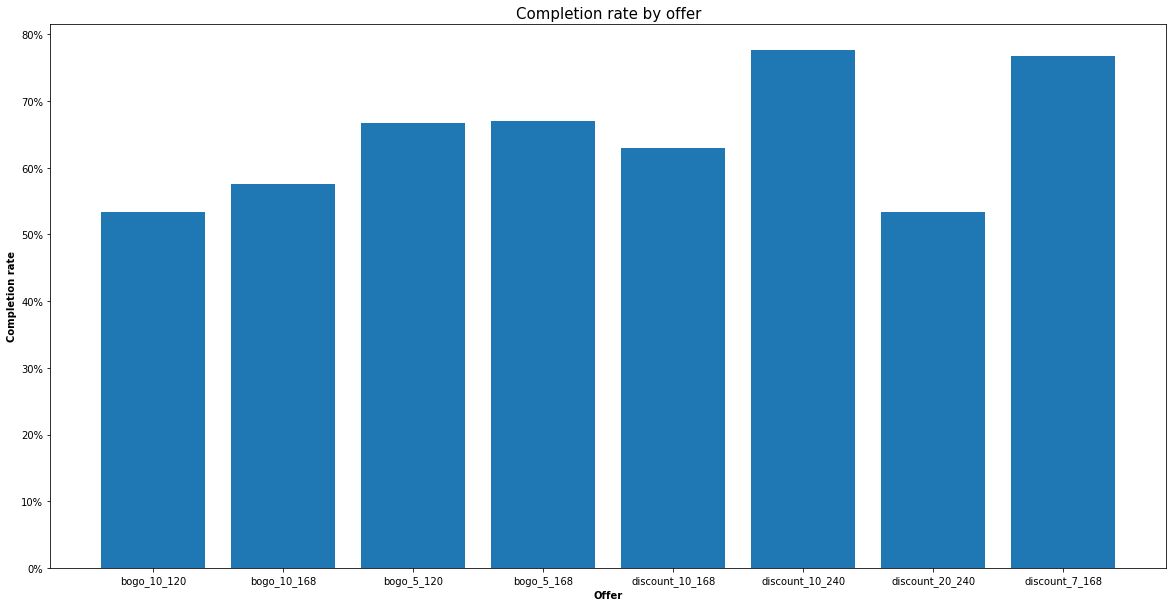

In [56]:
plt.figure(figsize=(20,10))
plt.bar(offer_success_rate.index.values, offer_success_rate.values)
plt.title('Completion rate by offer', fontsize = 15)
plt.xlabel('Offer', fontweight ="bold")
plt.ylabel('Completion rate', fontweight ="bold")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show();

The offer type discount with a difficulty of 0.5 and a duration of 240 hours has with 77.63% the highest completion rate, followed by another discount offer type with a difficulty of 0.35 and a duration of 168 hours with a 76.75% completion rate. In general it appears to be that the easier the offer, the higher the completion rate. Also the offer_type discount performs better then the bogo.

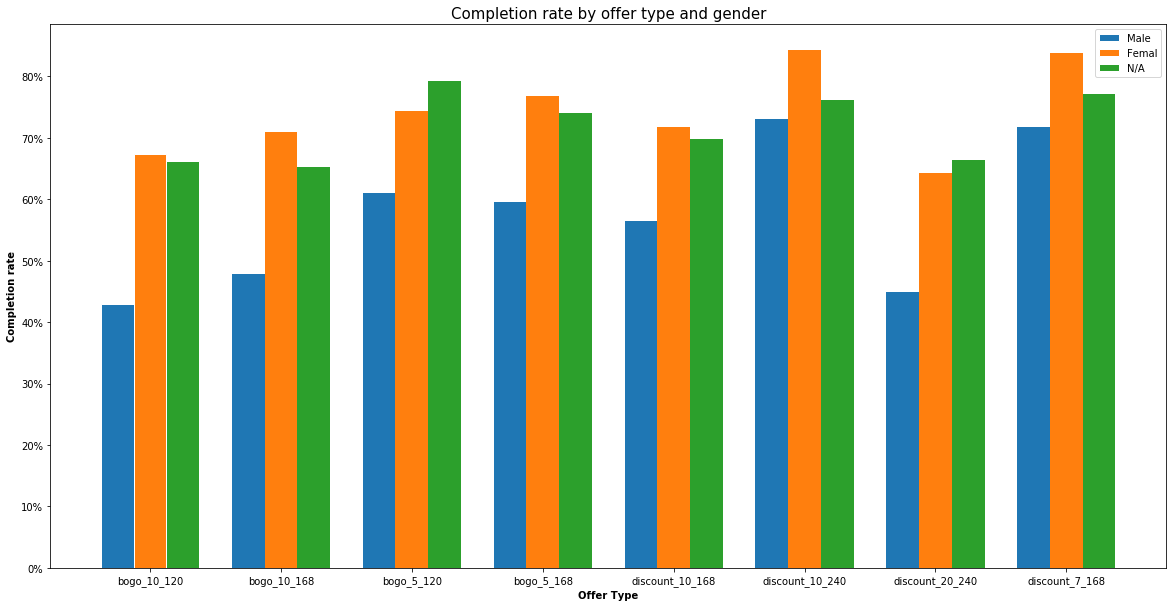

In [57]:
m_completed = (df_offer_merged[(df_offer_merged['gender'] == 'M') & (df_offer_merged['success'] == 1)].groupby('offer_name')['user_id'].count()/df_offer_merged[df_offer_merged['gender'] == 'M'].groupby('offer_name')['user_id'].count()).dropna() * 100
f_completed = (df_offer_merged[(df_offer_merged['gender'] == 'F') & (df_offer_merged['success'] == 1)].groupby('offer_name')['user_id'].count()/df_offer_merged[df_offer_merged['gender'] == 'F'].groupby('offer_name')['user_id'].count()).dropna() * 100
o_completed = (df_offer_merged[(df_offer_merged['gender'] == 'O') & (df_offer_merged['success'] == 1)].groupby('offer_name')['user_id'].count()/df_offer_merged[df_offer_merged['gender'] == 'O'].groupby('offer_name')['user_id'].count()).dropna() * 100
# set bar width
barWidth = 0.25

# set figure size
plt.figure(figsize=(20,10))

r1 = np.arange(len(m_completed.index.values))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
    
# set height of bar
plt.bar(r1, m_completed, width=barWidth, edgecolor='white', label='Male')
plt.bar(r2, f_completed, width=barWidth, edgecolor='white', label='Femal')
plt.bar(r3, o_completed, width=barWidth, edgecolor='white', label='N/A')
 
# Add xticks on the middle of the group bars
plt.title('Completion rate by offer type and gender', fontsize = 15)
plt.ylabel('Completion rate', fontweight ="bold")
plt.xlabel('Offer Type', fontweight ="bold")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.xticks([r + barWidth for r in range(len(m_completed.index.values))], m_completed.index.values)
plt.legend()
# Create legend & Show graphic
plt.show()

Female members have a 10% to 25% higher completion rate then male members consistently across all offer types.

In [58]:
# get the mean of duration by 'offer_name'
time_diff = df_offer_merged.groupby('offer_name')['time_diff'].mean().dropna()
# get the maximum amount of time a customer has to complete the offer by 'offer_name'
offer_duration = df_offer_merged.groupby('offer_name')['duration'].min()
# how fast was to offer completed in percent
time_diff_perc = (time_diff / offer_duration) * 100
# drop offer_name 'information' 
time_diff_perc = time_diff_perc.dropna()

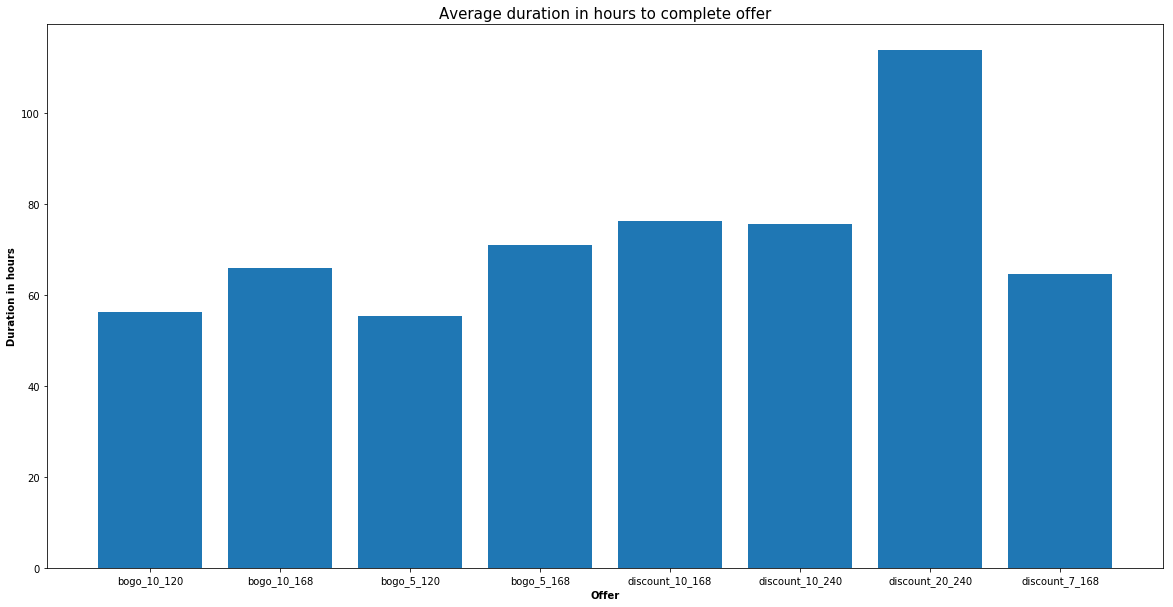

In [59]:
plt.figure(figsize=(20,10))
plt.bar(time_diff.index.values, time_diff.values)
plt.title('Average duration in hours to complete offer', fontsize = 15)
plt.xlabel('Offer', fontweight ="bold")
plt.ylabel('Duration in hours', fontweight ="bold")
plt.show();

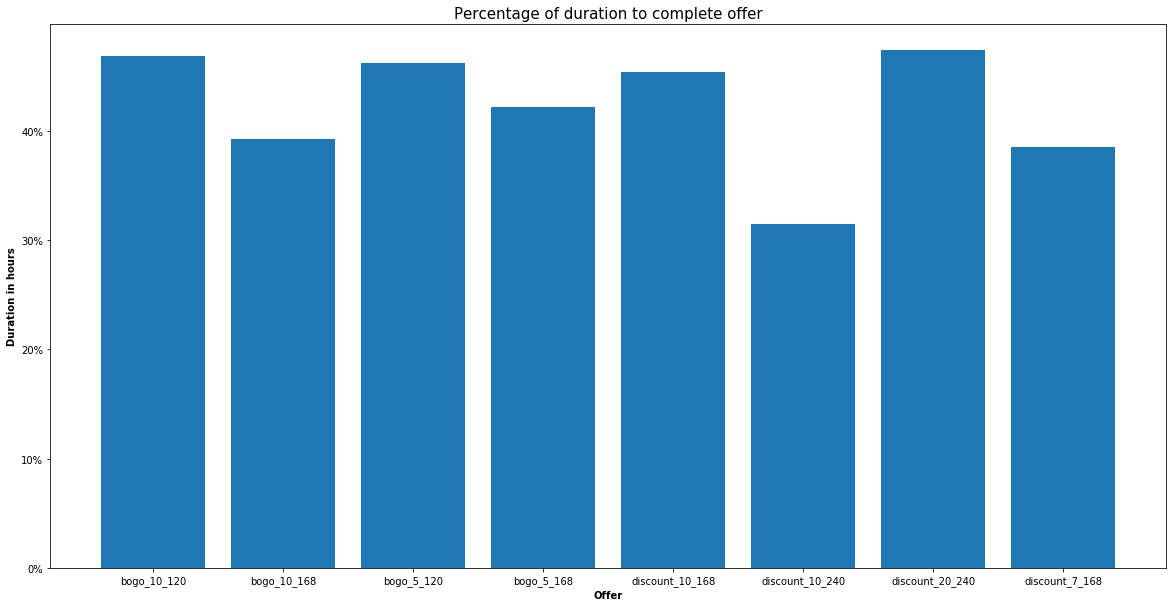

In [60]:
plt.figure(figsize=(20,10))
plt.bar(time_diff_perc.index.values, time_diff_perc.values)
plt.title('Percentage of duration to complete offer', fontsize = 15)
plt.xlabel('Offer', fontweight ="bold")
plt.ylabel('Duration in hours', fontweight ="bold")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show();

The average time it takes members to complete their respective offer is under 50% of the maximum offer duration.

In [61]:
# only get successful offers
df_success = df_offer_merged[df_offer_merged['success'] == 1]
# join 'df_success' with 'transactions' to analyze how much money was spent to complete an offer
df_success = df_success.merge(transactions, how = 'inner', on = 'user_id')
# only keep rows where transaction time is between 'time_received' and 'time_completed'
df_success = df_success[(df_success['time'] >= df_success['time_received']) & (df_success['time'] <= df_success['time_completed'])]
# group by 'offer_name' to get money spent on each offer
df_success = df_success.groupby('offer_name')['amount'].sum()
# total amount of money spent
total_spending = transactions['amount'].sum()
# percentage of money spent to complete offer vs. total money spent
not_successful_spending = total_spending - df_success.sum()

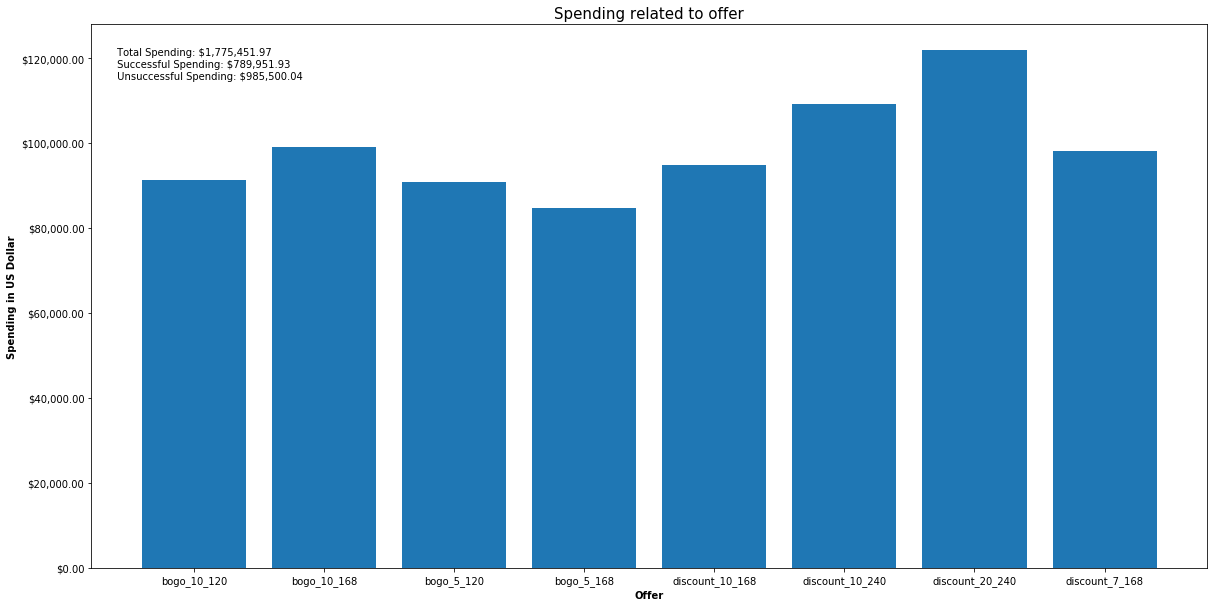

In [62]:
string = " Total Spending: ${:,.2f}  \n Successful Spending: ${:,.2f}  \n Unsuccessful Spending: ${:,.2f}".format(total_spending, df_success.sum(), not_successful_spending)
plt.figure(figsize=(20,10))
plt.bar(df_success.index.values, df_success.values)
plt.title('Spending related to offer', fontsize = 15)
plt.xlabel('Offer', fontweight ="bold")
plt.ylabel('Spending in US Dollar', fontweight ="bold")
plt.gca().set_yticklabels(['${:,.2f}'.format(x) for x in plt.gca().get_yticks()])
plt.annotate(string, xy=(0.02, 0.90), xycoords='axes fraction')
plt.show();

Roughly 44.5% of the spending can be tied to a completed offer.

# 4. ML Modeling

In [63]:
df_offer_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65527 entries, 0 to 65526
Data columns (total 40 columns):
user_id               65527 non-null object
time_received         65527 non-null int64
time_completed        33643 non-null float64
time_diff             33643 non-null float64
success               65527 non-null int64
difficulty            65527 non-null int64
duration              65527 non-null int64
offer_type            65527 non-null object
reward                65527 non-null int64
bogo                  65527 non-null uint8
discount              65527 non-null uint8
informational         65527 non-null uint8
email                 65527 non-null int64
mobile                65527 non-null int64
social                65527 non-null int64
web                   65527 non-null int64
offer_name            65527 non-null object
age                   65527 non-null int64
became_member_on      65527 non-null datetime64[ns]
gender                65527 non-null object
income        

In [64]:
# display all columns
pd.set_option('display.max_columns', None)
df_offer_merged.drop(['user_id', 'time_received', 'time_completed', 'time_diff', 'offer_type', 'offer_name', 'age', 'became_member_on', 'gender', 'income', 'became_member_year', 'income_group'], axis = 1, inplace = True)

In [65]:
df_offer_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65527 entries, 0 to 65526
Data columns (total 28 columns):
success          65527 non-null int64
difficulty       65527 non-null int64
duration         65527 non-null int64
reward           65527 non-null int64
bogo             65527 non-null uint8
discount         65527 non-null uint8
informational    65527 non-null uint8
email            65527 non-null int64
mobile           65527 non-null int64
social           65527 non-null int64
web              65527 non-null int64
member_days      65527 non-null int64
F                65527 non-null uint8
M                65527 non-null uint8
O                65527 non-null uint8
10s              65527 non-null int64
20s              65527 non-null int64
30s              65527 non-null int64
40s              65527 non-null int64
50s              65527 non-null int64
60s              65527 non-null int64
70s              65527 non-null int64
80s              65527 non-null int64
90s              

In [66]:
# normalize columns 'duration' and 'member_days'
# https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
df_offer_merged['duration'] = df_offer_merged['duration'] / df_offer_merged['duration'].abs().max()
df_offer_merged['member_days'] = df_offer_merged['member_days'] / df_offer_merged['member_days'].abs().max()
df_offer_merged['difficulty'] = df_offer_merged['difficulty'] / df_offer_merged['difficulty'].abs().max()
df_offer_merged['reward'] = df_offer_merged['reward'] / df_offer_merged['reward'].abs().max()

In [67]:
# split Dataframe df into X and y
X = df_offer_merged.iloc[:, 1:]
y = df_offer_merged['success']

In [68]:
# split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [69]:
# use RandomForestClassifier and GradientBoostingClassifier as a classifier
rfc = RandomForestClassifier(random_state = 42)
gbc = GradientBoostingClassifier(random_state = 42)

In [70]:
# train baisc models
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [71]:
# predict responses for basic models
rfc_y_pred = rfc.predict(X_test)
gbc_y_pred = gbc.predict(X_test)

In [72]:
print('Accuracy for RandomForestClassifier:', f1_score(y_test, rfc_y_pred))
print('Accuracy for GradientBoostingClassifier:', f1_score(y_test, gbc_y_pred))

Accuracy for RandomForestClassifier: 0.774154878926
Accuracy for GradientBoostingClassifier: 0.797380410023


The GradientBoostingClassifier outperforms the RandomForestClassifier. Hence, I'll go ahead and improve the better performing GradientBoostingClassifier classifier by using hyperparameter tuning. Cross validation is used to avoid overfitting.

In [73]:
gbc.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 42,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [74]:
# hyperparameter tuning and cross validation
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2, 5, 7],
    'max_depth' : [5, 6, 7, 8]
}
cv_gbc = GridSearchCV(gbc, param_grid = parameters, cv = 3, verbose = 2, n_jobs = 4)

In [75]:
# train improved model
cv_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] max_depth=5, min_samples_split=2, n_estimators=50 ...............
[CV] max_depth=5, min_samples_split=2, n_estimators=50 ...............
[CV] max_depth=5, min_samples_split=2, n_estimators=50 ...............
[CV] max_depth=5, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=50, total=  13.8s
[CV] max_depth=5, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=50, total=  14.1s
[CV] max_depth=5, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=50, total=  14.3s
[CV] max_depth=5, min_samples_split=2, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=100, total=  27.8s
[CV] max_depth=5, min_samples_split=2, n_estimators=150 ..............
[CV]  max_depth=5, min_samples_split=2, n_estimators=100, total=  27.5s
[CV] max_dept

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.8min


[CV]  max_depth=6, min_samples_split=2, n_estimators=50, total=  23.1s
[CV] max_depth=6, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=7, n_estimators=200, total=  58.9s
[CV] max_depth=6, min_samples_split=2, n_estimators=50 ...............
[CV]  max_depth=6, min_samples_split=2, n_estimators=50, total=  20.0s
[CV] max_depth=6, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=6, min_samples_split=2, n_estimators=50, total=  19.2s
[CV] max_depth=6, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=7, n_estimators=200, total=  58.4s
[CV] max_depth=6, min_samples_split=2, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=7, n_estimators=200, total=  58.9s
[CV] max_depth=6, min_samples_split=2, n_estimators=150 ..............
[CV]  max_depth=6, min_samples_split=2, n_estimators=100, total=  45.0s
[CV] max_depth=6, min_samples_split=2, n_estimators=150 ..............
[C

[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 36.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'n_estimators': [50, 100, 150, 200], 'min_samples_split': [2, 5, 7], 'max_depth': [5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [76]:
# display the best performing parameters
cv_gbc.best_params_

{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}

In [77]:
# predict responses for improved model
y_pred = cv_gbc.predict(X_test)

In [78]:
print('Accuracy:', f1_score(y_test, y_pred))

Accuracy: 0.8134735874


Using GridSearchCV improves the GradientBoostingClassifier by around 1.5%.

# 4. Summary

In this Capstone project I tried to analyze the socio-demographics of the Starbucks members included in this data set and explore how well certain customers respond to each offer (Bogo or Discount). At the end of this challenge, I build a model that predicts if a member will complete an offer or not.

In order to perform the analysis I first had to clean the three data sets, which was the most time consuming part of this challenge. There were some data quality issues present. For example there are 2,175 NULL values in the columns 'gender' and 'income' and members with an age of 118 years included in data set 'profile'. Also certain columns like 'age' or 'income' were transformed into categorical values. Also the transcript data set was split into two separate DataFrames, one called 'transactions' and 'transcript_clean'.

After the cleaning process was completed I tried to gain more insights in regards to the socio-demographics of the Starbucks members and how the respond to each individual offer. Here are some insights:

- Starbucks has a growing member base every year.
- Most of the Starbucks members are in their 50's and 60's.
- There are three different gender categories included in this data set (8,484 male, 6,129 female, 212 O or N/A).
- Bogo offer have a higher viewing rate than discount offers. Although, discount offers have a higher completion rate than Bogo offers.
- Female members have a 10% to 25% higher completion rate then male members consistently across all offer types.
- Offers are being completed in average in under 50% of the offer duration.

At the end, I compared the RandomForestClassifier to the GradientBoostingClassifier to determine which classifier makes better predictions on how a member responds to offers. The GradientBoostingClassifier outperformed the RandomForestClassifier. Hence, I used the GradientBoostingClassifier and tried to improve it by using hyperparameter tuning through GridSearchCV. The hyperparameter tuning resulted in a 1.5% improvement of the model.

If I would like to make further improvements to the model, I would have to revisit the features I used and see if there are any other features that might have an impact on the performance of the model.